In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
#train function and stock the values in the lists
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # create lists to store the results for each epoch of the trained model
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return [model,val_acc]

In [4]:
def grid_search_cv(param_grid, criterion, dataloaders, dataset_sizes):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    

    best_model = None
    best_acc = 0.0
    
    for lr in param_grid['lr']:
        for weight_decay in param_grid['weight_decay']:
            
            print(f'testing the following combination : {lr} learning rate and {weight_decay} weight decay')
            
            model = models.resnet18(pretrained=True)
            model = model.to(device)
            
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
            trained_model = train_model(model, criterion, optimizer, scheduler)
            val_acc = trained_model[1]
            
            if best_acc < max(val_acc):
                best_acc = max(val_acc)
                best_model = copy.deepcopy(trained_model[0])
                best_lr = lr
                best_weight_decay = weight_decay
                
    print(f'the best parameters combination is a learning rate of {best_lr} and weight decay of {best_weight_decay}')
    return best_model, best_lr, best_weight_decay

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.empty_cache()

In [7]:
param_grid = {'lr': [0.001, 0.01, 0.1], 'weight_decay': [1e-4, 1e-6, 1e-8]}
criterion = nn.CrossEntropyLoss().to(device)

In [8]:
best_model = grid_search_cv(param_grid, criterion, dataloaders, dataset_sizes)

testing the following combination : 0.001 learning rate and 0.0001 weight decay
Epoch 0/9
----------


C:\Users\thoma\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6234 Acc: 0.8292
val Loss: 0.1959 Acc: 0.9271

Epoch 1/9
----------
train Loss: 0.2122 Acc: 0.9301
val Loss: 0.1346 Acc: 0.9543

Epoch 2/9
----------
train Loss: 0.1495 Acc: 0.9523
val Loss: 0.1079 Acc: 0.9650

Epoch 3/9
----------
train Loss: 0.1207 Acc: 0.9608
val Loss: 0.1081 Acc: 0.9654

Epoch 4/9
----------
train Loss: 0.0912 Acc: 0.9716
val Loss: 0.0961 Acc: 0.9689

Epoch 5/9
----------
train Loss: 0.0771 Acc: 0.9766
val Loss: 0.0954 Acc: 0.9700

Epoch 6/9
----------
train Loss: 0.0621 Acc: 0.9812
val Loss: 0.1019 Acc: 0.9664

Epoch 7/9
----------
train Loss: 0.0499 Acc: 0.9855
val Loss: 0.0933 Acc: 0.9714

Epoch 8/9
----------
train Loss: 0.0452 Acc: 0.9874
val Loss: 0.0986 Acc: 0.9729

Epoch 9/9
----------
train Loss: 0.0435 Acc: 0.9888
val Loss: 0.0933 Acc: 0.9707

Training complete in 11m 2s
Best val Acc: 0.972857
testing the following combination : 0.001 learning rate and 1e-06 weight decay
Epoch 0/9
----------
train Loss: 0.6330 Acc: 0.8272
val Loss: 0.1701 Ac

val Loss: 0.1014 Acc: 0.9657

Epoch 8/9
----------
train Loss: 0.0518 Acc: 0.9830
val Loss: 0.1008 Acc: 0.9664

Epoch 9/9
----------
train Loss: 0.0465 Acc: 0.9844
val Loss: 0.1004 Acc: 0.9682

Training complete in 17m 37s
Best val Acc: 0.968214
the best parameters combination is a learning rate of 0.01 and weight decay of 0.0001


In [9]:
#save the model
torch.save(best_model[0].state_dict(), 'best_ResNet.pth')

### Visualisation

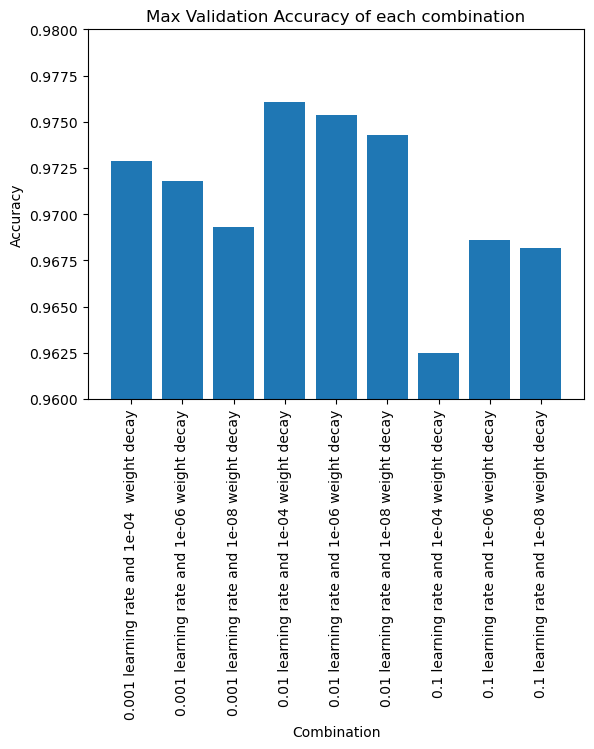

In [11]:
combination = ['0.001 learning rate and 1e-04  weight decay',
               '0.001 learning rate and 1e-06 weight decay',
               '0.001 learning rate and 1e-08 weight decay',
               '0.01 learning rate and 1e-04 weight decay',
               '0.01 learning rate and 1e-06 weight decay',
               '0.01 learning rate and 1e-08 weight decay',
               '0.1 learning rate and 1e-04 weight decay',
               '0.1 learning rate and 1e-06 weight decay',
               '0.1 learning rate and 1e-08 weight decay']

val_acc = [0.9729, 0.9718, 0.9693, 0.9761, 0.9754, 0.9743, 0.9625, 0.9686, 0.9682]

plt.bar(combination, val_acc)
plt.xlabel('Combination')
plt.ylabel('Accuracy')
plt.title('Max Validation Accuracy of each combination')
plt.ylim(0.96, 0.98, 0.001)
plt.xticks(rotation=90)
plt.show()